# State Level Comparisons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    # read directly from NYT's github repo for the freshest data
    states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
except:
    # unless it's not available in which case read locally after pulling the repo from upstream
    # (assumes you've added the NYT repo as upstream with 
    #     $ remote add upstream https://github.com/nytimes/covid-19-data.git)
    !git pull upstream master
    states = pd.read_csv('us-states.csv')

In [21]:
# define a function to chart the same metric for multiple states at the same time
# los is a list of states, default is deaths
def compare_states(los,var='deaths'):
    tmp = states.loc[(states.state.isin(los)) & (states[var] >= 1)][['date','state',var]]
    plt.figure(figsize=(8, 6))
    plt.title('US COVID-19 Trends by State ('+var+')')
    lm = sns.lineplot(x=tmp['date'],y=tmp[var],hue=tmp['state'])
    plt.yscale('log')
    lm.axes.get_xaxis().get_label().set_visible(False)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))

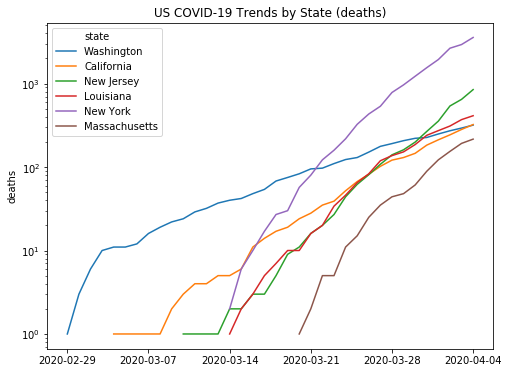

In [17]:
compare_states(['California','New York','Washington','Louisiana','Massachusetts','New Jersey'])

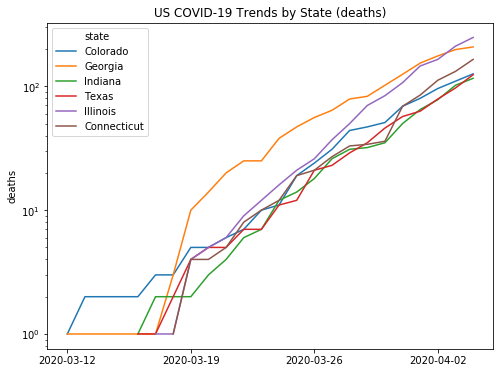

In [18]:
compare_states(['Texas','Georgia','Connecticut','Colorado','Indiana','Illinois'])

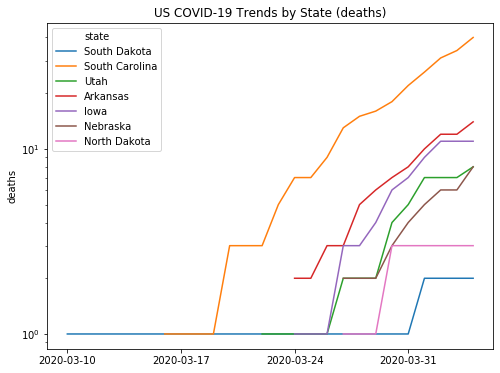

In [19]:
compare_states(['Arkansas', 'Iowa', 'Nebraska', 'North Dakota', 'South Dakota', 'South Carolina', 'Utah', 'Wyoming'])

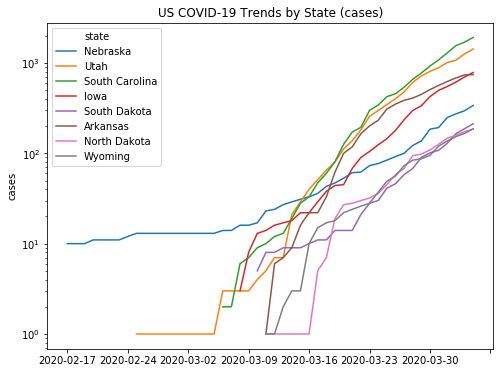

In [20]:
compare_states(['Arkansas', 'Iowa', 'Nebraska', 'North Dakota', 'South Dakota', 'South Carolina', 'Utah', 'Wyoming'],'cases')